In [20]:
import matplotlib.pyplot as plt
import matplotlib.image as npimg 
import numpy as np
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import cv2
import glob
import matplotlib.patches as patches
from scipy import signal as sg
import utils as u
%matplotlib inline

In [24]:
original_image = u.load_image('test_images/straight_lines1.jpg')

In [25]:
undistorted_image = u.undistort(original_image)
hsv_image = cv2.cvtColor(undistorted_image, cv2.COLOR_RGB2HSV)
binary_image = u.binarify(hsv_image)

topdown_image = u.first2bird(binary_image)

In [46]:
image = topdown_image
num_windows = 10
window_offset = 100
image_height, image_width  = image.shape
midpoint = np.int(image_width/2)

# 4/7ths of the lower part of the image is measured to find where the most pixels are
# Then we use this as a starting point to find the lane lines.
histogram = np.sum(image[int(4*image_height/7):,:], axis=0)

#now we split the image in half, which caused problems becuase sometimes the lanes are on one side of the image
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

window_height = image_height/num_windows

leftx, rightx = leftx_base, rightx_base
leftleft, leftright, rightleft, rightright = leftx-window_offset, leftx+window_offset, rightx-window_offset, rightx+window_offset
lane_lines = np.zeros_like(image)

leftpointy, leftpointx, rightpointy, rightpointx = 0,0,0,0

for y_high in range(int(num_windows*window_height), 0, int(-window_height)):

        y_low = int(y_high-window_height)

        lhistogram = np.sum(image[y_low:y_high,leftleft:leftright], axis=0)
        rhistogram = np.sum(image[y_low:y_high,rightleft:rightright], axis=0)

        if lhistogram.size !=0:
            if np.max(lhistogram):
                leftx = np.argmax(lhistogram)+leftleft
        if rhistogram.size !=0:
            if np.max(rhistogram):
                rightx = np.argmax(rhistogram)+rightleft

        leftleft, leftright, rightleft, rightright = leftx-window_offset, leftx+window_offset, rightx-window_offset, rightx+window_offset

        tempy, tempx =  np.nonzero(image[y_low:y_high, leftleft:leftright])
        leftpointy, leftpointx =  np.nonzero(image[y_low:y_high, leftleft:leftright])
        tempy, tempx =  np.nonzero(image[y_low:y_high, rightleft:rightright])
        rightpointy, rightpointx =  np.nonzero(image[y_low:y_high, rightleft:rightright])
        
        
        lane_lines[y_low:y_high, leftleft:leftright] = image[y_low:y_high, leftleft:leftright]
        lane_lines[y_low:y_high, rightleft:rightright] = image[y_low:y_high, rightleft:rightright]



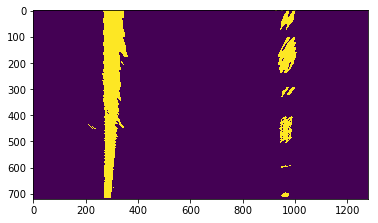

In [47]:
plt.imshow(lane_lines)
plt.show()

In [48]:
left_fit = np.polyfit(leftpointy, leftpointx, 2)
right_fit = np.polyfit(rightpointy, rightpointx, 2)

In [49]:
left_fit, right_fit

(array([  1.83258577e-03,  -1.75937252e-01,   1.36960693e+02]),
 array([ -6.25923235e-03,   1.21102428e-01,   1.06789810e+02]))

In [50]:
laned_image = drawlane(left_fit, right_fit, undistorted_image)

error: /home/travis/miniconda/conda-bld/conda_1486587071158/work/opencv-3.1.0/modules/core/src/matrix.cpp:1052: error: (-215) cn <= 4 in function scalarToRawData


In [36]:
def drawlane(left_fit, right_fit, image):

    if ((np.all(left_fit != 0)) & (np.all(right_fit != 0))):
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(image).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        #
        ploty = np.linspace(0, 719, num=720)
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        y_eval = np.max(ploty)

        #
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        #Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
        newwarp = u.bird2first(color_warp)
        result = cv2.addWeighted(laned_image, 1, newwarp, 0.3, 0)

        return result

    else:
        return image

In [15]:
# Define a class to receive the characteristics of each line detection
class Line:
    def __init__(self):
        # Left and right lane curvature in meters. Used to sanity check new frames.
        self.leftcurves = np.array([[0,0,0] for i in range(10)])
        self.rightcurves = np.array([[0,0,0] for i in range(10)])
        
        self.left = [0]*3
        self.right = [0]*3
        
    def check_sanity(self, leftfit, rightfit):
        left, right = self.left, self.right
        ranges = [[.8, 1.2], [.7, 1.3], [.6, 1.4]]
        return True

    def recalculateaveragelines(self):
        self.left = np.mean(self.leftcurves[np.nonzero(self.leftcurves)])
        self.right = np.mean(self.rightcurves[np.nonzero(self.rightcurves)])
    
    def add(self, leftfit, rightfit):
        self.leftcurves = np.append(self.leftcurves, leftfit)
        self.rightcurves = np.append(self.rightcurves, rightfit)
        np.delete(self.leftcurves, 0)
        np.delete(self.rightcurves, 0)
        self.recalculateaveragelines()     
   
    def send_data(self, leftfit, rightfit):    
        if ( self.check_sanity(leftfit, rightfit) ):
            self.add(leftfit, rightfit)

    def get_data(self):
        return self.left, self.right

In [16]:
Lane_checker = Line()
def LaneLineDetector(original_image):
    
    undistorted_image = u.undistort(original_image)
    hsv_image = cv2.cvtColor(undistorted_image, cv2.COLOR_RGB2HSV)
    binary_image = u.binarify(hsv_image)

    topdown_image = u.first2bird(binary_image)
    left_fit, right_fit = lanefinder(topdown_image)

    laned_image = drawlane(left_fit, right_fit, undistorted_image)

    return laned_image

        #print(left_fit, right_fit)
        #Lane_checker.add(left_fit, right_fit)
        #left_fit, right_fit = Lane_checker.get_data()

# Tests

## Challenge video

In [6]:
final_clip_output = 'challenge2.mp4'
clip = VideoFileClip("project_video.mp4")
final_clip = clip.fl_image(LaneLineDetector)
%time final_clip.write_videofile(final_clip_output, audio=False)

NameError: name 'lefty' is not defined

In [ ]:
HTML("""
<video width="960" height="520" controls>
  <source src="{0}" type="video/mp4">
</video>
""".format(final_clip_output))

In [ ]:
def lanefinder(image, num_windows = 10, window_offset = 100):

    
    return left_fit, right_fit

def fitlanes(laned_image, boxes):

    y, x = np.nonzero(laned_image)
    
    left_fit = np.polyfit(lefty, leftx, 2)

    right_fit = np.polyfit(righty, rightx, 2)

    return left_fit, right_fit

Sanity Check

    Ok, so your algorithm found some lines. Before moving on, you should check that the detection makes sense. 
    To confirm that your detected lane lines are real, you might consider:

    Checking that they have similar curvature
    Checking that they are separated by approximately the right distance horizontally
    Checking that they are roughly parallel

Look-Ahead Filter

    Once you've found the lane lines in one frame of video, and you are reasonably confident they are actually the lines you are looking for, you don't need to search blindly in the next frame. You can simply search within a window around the previous detection.

    For example, if you fit a polynomial, then for each y position, you have an x position that represents the lane center from the last frame. Search for the new line within +/- some margin around the old line center.

Reset

    If your sanity checks reveal that the lane lines you've detected are problematic for some reason, you can simply assume it was a bad or difficult frame of video, retain the previous positions from the frame prior and step to the next frame to search again. If you lose the lines for several frames in a row, you should probably start searching from scratch using a histogram and sliding window, or another method, to re-establish your measurement.

Smoothing

    Even when everything is working, your line detections will jump around from frame to frame a bit and it can be preferable to smooth over the last n frames of video to obtain a cleaner result. Each time you get a new high-confidence measurement, you can append it to the list of recent measurements and then take an average over n past measurements to obtain the lane position you want to draw onto the image.

